# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Structured Streaming** </center>
---

**Date**: October, 2025

**Student Name**: Juan Alonso

**Professor**: Pablo Camarillo Ramirez

# Producer

In [ ]:
import time
import json
import random

from kafka import KafkaProducer
from kafka.errors import NoBrokersAvailable
from lib.juanalonso.flight_data_generator import FlightDataGenerator

KAFKA_SERVER = "kafka:9093"
TOPIC_NAME = "flight_tickets_stream"

def json_serializer(data):
    return json.dumps(data).encode("utf-8")

if __name__ == "__main__":
    print("Iniciando productor de tickets de vuelo...")

    try:
        generator = FlightDataGenerator()

        producer = KafkaProducer(
            bootstrap_servers=[KAFKA_SERVER],
            value_serializer=json_serializer
        )

        print(f"Conectado a Kafka en {KAFKA_SERVER}. Enviando datos al topic '{TOPIC_NAME}'...")

        while True:
            ticket_record = generator.generate_ticket_record()

            print(f"Produciendo Ticket ID: {ticket_record['ticket_id']}")
            producer.send(TOPIC_NAME, value=ticket_record)

            time.sleep(random.uniform(0.5, 2.0))

    except NoBrokersAvailable:
        print(f"Error: No se pudo conectar a Kafka en {KAFKA_SERVER}.")
        print("Asegúrate de que tu clúster de Kafka esté corriendo.")
    except KeyboardInterrupt:
        print("\nDeteniendo productor...")
    finally:
        if 'producer' in locals() and producer:
            print("Cerrando conexión con Kafka.")
            producer.flush()
            producer.close()


Iniciando productor de tickets de vuelo...
Conectado a Kafka en kafka:9093. Enviando datos al topic 'flight_tickets_stream'...
Produciendo Ticket ID: ed5393f2-9ed4-434c-a5bb-4c4802c50fb3
Produciendo Ticket ID: ad6e316c-5dd6-4f80-a577-4233573e675f
Produciendo Ticket ID: 3d91de9a-a926-4075-a540-cedba3392274
Produciendo Ticket ID: 473d7128-6427-42e8-9a0d-3369a2c9fd73
Produciendo Ticket ID: 352f4e38-fff9-4848-ae19-01d0bd3c39f4
Produciendo Ticket ID: d5405765-460d-4d2b-8d2a-cfdfc6ea5ab1
Produciendo Ticket ID: de81210c-75fd-4636-b511-0844dff63bc5
Produciendo Ticket ID: 395fb284-1b70-4066-a707-55db01fdd602
Produciendo Ticket ID: 203448cf-e0fd-40b6-89c0-4fdf6a9b794b
Produciendo Ticket ID: 5f346645-5d64-4e2e-856a-a1ea599fb277
Produciendo Ticket ID: 36516010-7759-4043-8093-bb2ff7078833
Produciendo Ticket ID: fe3aa150-52ea-49ee-a0d4-0899578aaa17
Produciendo Ticket ID: e8e6496b-c629-4615-8036-8f69302c0b3b
Produciendo Ticket ID: 3bae8c2b-86b2-4ff7-884e-2171eb4685ec


Produciendo Ticket ID: c1fc4bc0-5084-495c-a586-80a5ba6e1bdf
Produciendo Ticket ID: a91b0f57-214a-4366-97cb-1847397c6436

Deteniendo productor...
Cerrando conexión con Kafka.


# Consumer

In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_json, to_date
from juanalonso.spark_utils import SparkUtils, normalize_stops, add_route, encode_times, add_is_expensive

spark = SparkSession.builder \
    .appName("ProyectoFinalStream_FlightTickets") \
    .master("local[*]") \
    .config("spark.jars.packages",
            "org.apache.spark:spark-sql-kafka-0-10_2.13:4.0.0") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("WARN")


:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.apache.spark#spark-sql-kafka-0-10_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-a5c9bbcb-feb9-4422-90f9-56cc325a5711;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.13;4.0.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.13;4.0.0 in central
	found org.apache.kafka#kafka-clients;3.9.0 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.7 in central
	found org.slf4j#slf4j-api;2.0.16 in central
	found org.apache.hadoop#hadoop-client-runtime;3.4.1 in central
	found org.apache.hadoop#hadoop-client-api;3.4.1 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.scala-lang.modules#scala-parallel-collections_2.13;1.2.0

### Dataset and Stream creation

In [10]:
schema_columns = [
    ("ticket_id", "StringType"),
    ("airline", "StringType"),
    ("source_city", "StringType"),
    ("destination_city", "StringType"),
    ("departure_time", "StringType"),
    ("arrival_time", "StringType"),
    ("stops", "StringType"),
    ("duration", "DoubleType"),
    ("days_left", "IntegerType"),
    ("booking_date", "StringType"),
    ("travel_date", "StringType"),
    ("price", "DoubleType"),
]

tickets_schema = SparkUtils.generate_schema(schema_columns)

In [11]:
kafka_df = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka:9093") \
    .option("subscribe", "flight_tickets_stream") \
    .load()

In [12]:
parsed_df = kafka_df.select(
    from_json(col("value").cast("string"), tickets_schema).alias("data")
).select("data.*")

df_with_dates = parsed_df \
    .withColumn("booking_date", to_date(col("booking_date"), "yyyy-MM-dd")) \
    .withColumn("travel_date", to_date(col("travel_date"), "yyyy-MM-dd"))

### Transformations and Actions

In [13]:
from pyspark.sql import functions as F

df_cleaned = df_with_dates \
    .dropna(subset=["ticket_id", "airline", "source_city",
                    "destination_city", "price", "travel_date"]) \
    .withColumn("airline", F.trim(col("airline"))) \
    .withColumn("source_city", F.trim(col("source_city"))) \
    .withColumn("destination_city", F.trim(col("destination_city")))

df_stops = normalize_stops(df_cleaned)
df_route = add_route(df_stops)
df_times = encode_times(df_route)
df_exp = add_is_expensive(df_times)

df_final = df_exp \
    .withColumn("booking_year", F.year(col("booking_date"))) \
    .withColumn("booking_month", F.month(col("booking_date"))) \
    .withColumn("is_last_minute", (col("days_left") <= 3).cast("boolean"))

df_final.printSchema()


root
 |-- ticket_id: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- source_city: string (nullable = true)
 |-- destination_city: string (nullable = true)
 |-- departure_time: string (nullable = true)
 |-- arrival_time: string (nullable = true)
 |-- stops: integer (nullable = true)
 |-- duration: double (nullable = true)
 |-- days_left: integer (nullable = true)
 |-- booking_date: date (nullable = true)
 |-- travel_date: date (nullable = true)
 |-- price: double (nullable = true)
 |-- route: string (nullable = false)
 |-- departure_time_id: integer (nullable = true)
 |-- arrival_time_id: integer (nullable = true)
 |-- is_expensive: boolean (nullable = true)
 |-- booking_year: integer (nullable = true)
 |-- booking_month: integer (nullable = true)
 |-- is_last_minute: boolean (nullable = true)



/opt/spark/python/pyspark/sql/classic/column.py:359: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


### Persistence Data

In [ ]:
OUTPUT_PATH = "/opt/spark/work-dir/data/juanalonso/flight_output"
CHECKPOINT_PATH = "/opt/spark/work-dir/data/juanalonso/checkpoints/flight_tickets"

query = df_final.writeStream \
    .format("parquet") \
    .outputMode("append") \
    .partitionBy("booking_year", "booking_month", "airline") \
    .option("path", OUTPUT_PATH) \
    .option("checkpointLocation", CHECKPOINT_PATH) \
    .trigger(processingTime="30 seconds") \
    .start()

query.awaitTermination()

25/11/24 04:00:22 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/11/24 04:00:22 WARN StreamingQueryManager: Stopping existing streaming query [id=299b45a7-8ec8-42e3-9fce-539645abb2e9, runId=f18fe3fe-daba-44aa-a064-dfef9e1c65c3], as a new run is being started.
25/11/24 04:00:22 WARN DAGScheduler: Failed to cancel job group f18fe3fe-daba-44aa-a064-dfef9e1c65c3. Cannot find active jobs for it.
25/11/24 04:00:23 WARN DAGScheduler: Failed to cancel job group f18fe3fe-daba-44aa-a064-dfef9e1c65c3. Cannot find active jobs for it.
ERROR:root:KeyboardInterrupt while sending command.                             
Traceback (most recent call last):
  File "/opt/spark/python/lib/py4j-0.10.9.9-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/spark/python/lib/py4j-0.10.9.9-src.zip/py4j/clientserver.py", line 535, in send_command
    answer = smart_deco

KeyboardInterrupt: 

### Power BI Dashboard

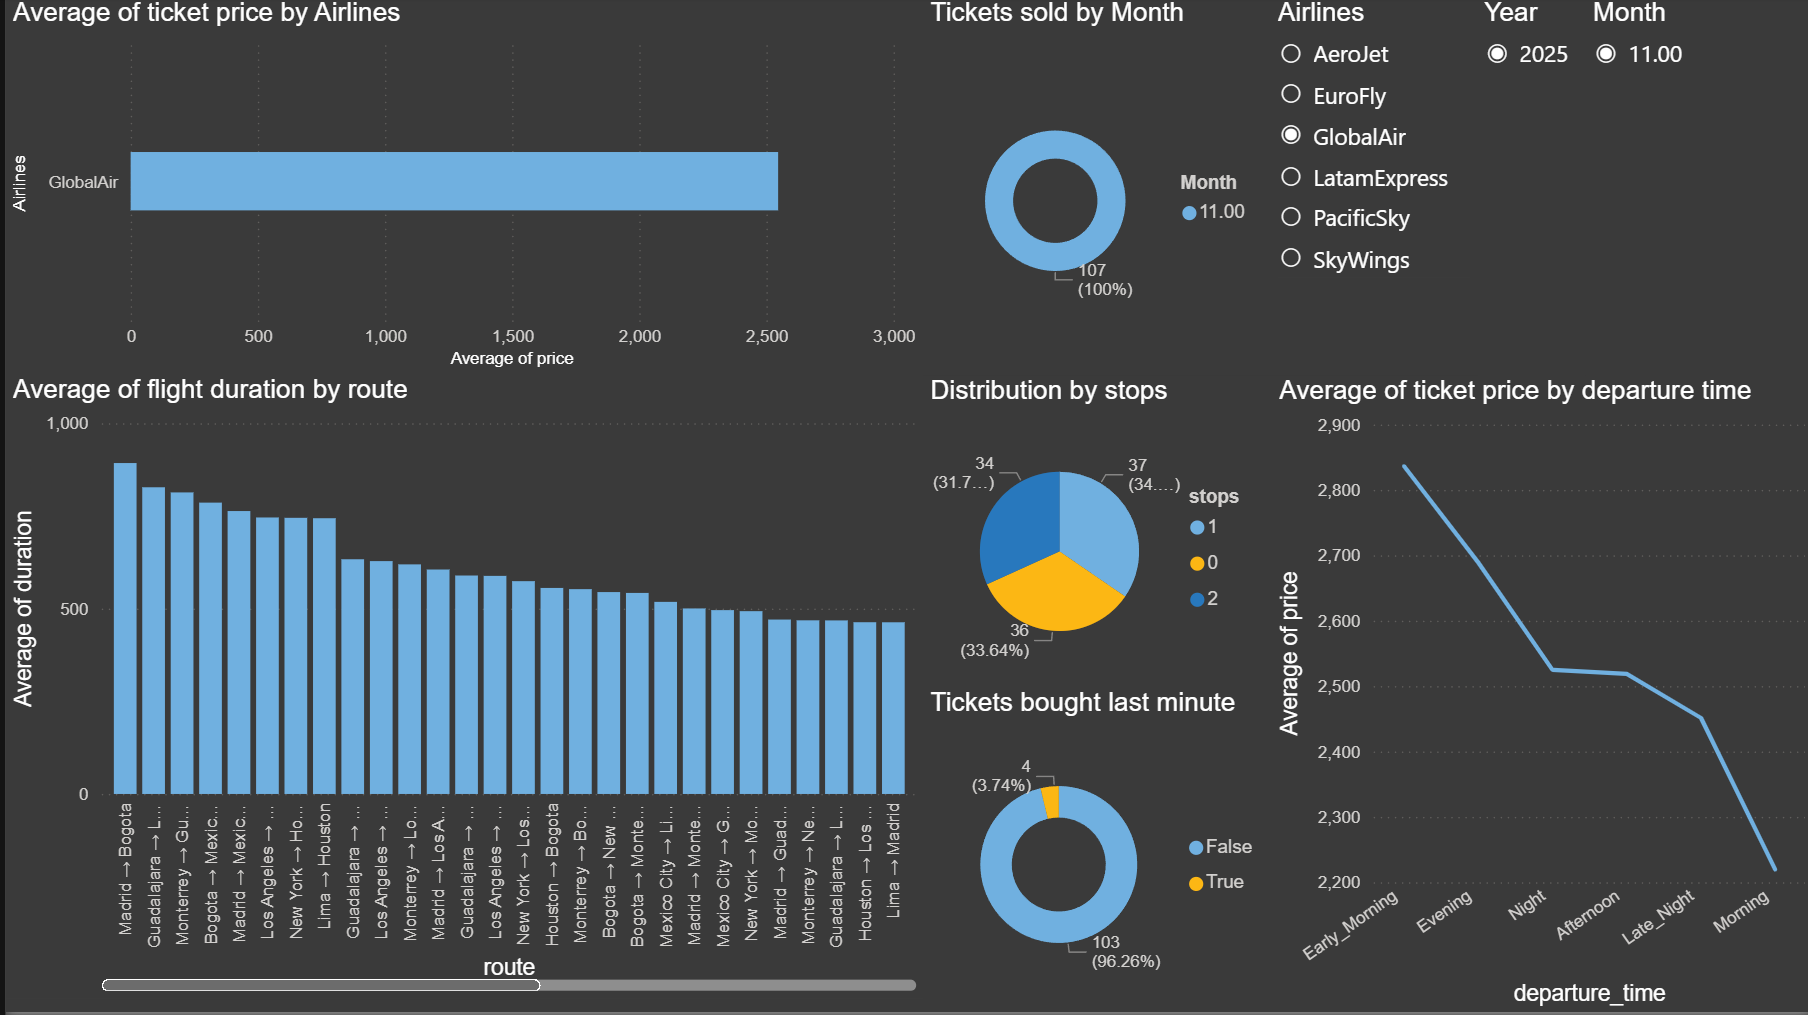